In [79]:
%matplotlib inline

In [77]:
import csv
from math import floor
from datetime import datetime
import re
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Company(object):
    def __init__(self, compId):
        self.id = int(compId)
        self.name = ""
        self.ticker = ""
        self.industryCode = 0
        self.finYearMonthEnd = 0
        self.data = []
        self.startDateComplete = None
        self.helperComplete = True

    def __str__(self):
        return "id: " + str(self.id) + ", name: " + str(self.name) + ",  ticker: " + str(self.ticker) + ", data: " + ",".join(str(x) for x in self.data)

    def appendValue(self, indicatorIndex, value):
        self.data[indicatorIndex].values.append(value)

    def setDateComplete(self,indicatorIndex, dateObj):
        self.data[indicatorIndex].startDateComplete = dateObj
        if dateObj is not None and self.helperComplete:
            if self.startDateComplete is None or dateObj > self.startDateComplete:
                self.startDateComplete = dateObj
        else:
            self.helperComplete = False
            self.startDateComplete = None

class Indicator:
    def __init__(self, name,indicatorId):
        self.name = name
        self.values = []
        self.indicatorId = indicatorId
        self.startDateComplete = None

    def __str__(self):
        return "{name: " + str(self.name) + ", indicatorId: "+str(self.indicatorId)+", len(values): " + str(len(self.values)) + "}"

class SimFinDataset:
    def __init__(self, dataFilePath, csvDelimiter = "semicolon", startDate = "", endDate = "", excludeMissing = False, companyClass=Company):

        self.numIndicators = None
        self.numCompanies = 1

        self.quarterPattern = re.compile(r'(\w)(\d)-(\d{4})')

        self.companies = []
        self.tickers = []
        self.timePeriods = []
        self.timePeriodsDates = []
        self.timePeriodFormat = None

        self.numDescriptionRows = 7
        self.excludeMissing = excludeMissing

        self.startDatetime = None
        self.endDatetime = None
        self.startIndexLimit = None
        self.endIndexLimit = None
        if startDate != "":
            self.startDatetime = datetime.strptime(startDate,"%Y-%m-%d")
        if endDate != "":
            self.endDatetime = datetime.strptime(endDate, "%Y-%m-%d")

        # load data
        self.loadData(dataFilePath, csvDelimiter, companyClass)

        self.numTimePeriods = len(self.timePeriods)

        # if complete companies only are requested, filter out the ones that have missing data
        if excludeMissing:
            cutDate = self.startDatetime if self.startDatetime is not None else self.timePeriodsDates[0]
            for a in range(self.numCompanies-1,-1,-1):
                if self.companies[a].startDateComplete is None or self.companies[a].startDateComplete > cutDate:
                    self.deleteCompanyAtIndex(a)

    def loadData(self, filePath, delimiter, companyClass=Company):

        def getCompIndex(index,numIndicators):
            return int(floor((index - 1) / float(numIndicators)))

        def getIndicatorIndex(index,numIndicators,compIndex):
            return index - 1 - (numIndicators * compIndex)

        numRow = 0

        delimiterChar = ";" if delimiter == "semicolon" else ","

        csvfile = open(filePath, 'r')
        reader = csv.reader(csvfile, delimiter=delimiterChar, quotechar='"')
        row_count = sum(1 for _ in reader)
        csvfile.seek(0)

        for row in reader:
            numRow += 1
            if numRow > 1 and numRow != row_count and numRow != row_count-1:
                # info rows for company
                if numRow <= 7:
                    # company id row
                    if numRow == 2:
                        rowLen = len(row)
                        idVal = None
                        for index, columnVal in enumerate(row):
                            if index > 0:
                                if idVal is not None and idVal != columnVal:
                                    self.numCompanies += 1
                                    if self.numIndicators is None:
                                        self.numIndicators = index - 1
                                    # add last company
                                    self.companies.append(companyClass(idVal))
                                if index + 1 == rowLen:
                                    if self.numIndicators is None:
                                        self.numIndicators = index
                                    # add last company in file
                                    self.companies.append(companyClass(columnVal))
                                idVal = columnVal
                    if numRow > 2 and self.numIndicators is None:
                        return
                    # company name row
                    if numRow == 3:
                        for a in range(0, self.numCompanies):
                            self.companies[a].name = row[(a * self.numIndicators) + 1]
                    # company ticker row
                    if numRow == 4:
                        for a in range(0, self.numCompanies):
                            self.companies[a].ticker = row[(a * self.numIndicators) + 1]
                            self.tickers.append(self.companies[a].ticker)
                    # company financial year end row
                    if numRow == 5:
                        for a in range(0, self.numCompanies):
                            self.companies[a].finYearMonthEnd = row[(a * self.numIndicators) + 1]
                    # company industry code row
                    if numRow == 6:
                        for a in range(0, self.numCompanies):
                            self.companies[a].industryCode = row[(a * self.numIndicators) + 1]
                    # indicator name row
                    if numRow == 7:
                        for a in range(0, self.numCompanies):
                            for b in range(0, self.numIndicators):
                                self.companies[a].data.append(Indicator(row[(a * self.numIndicators + b) + 1],b))
                else:
                    # actual data
                    inDateRange = False
                    for index, columnVal in enumerate(row):
                        if index == 0:

                            # set time period format
                            if self.timePeriodFormat is None:
                                if self.quarterPattern.match(columnVal):
                                    self.timePeriodFormat = "quarters"
                                else:
                                    self.timePeriodFormat = "dates"

                            currentDate = self.getDateFromStr(columnVal)

                            # check if in date range
                            if (self.startDatetime is None or currentDate >= self.startDatetime) and (self.endDatetime is None or currentDate <= self.endDatetime):
                                inDateRange = True

                            if inDateRange:
                                self.timePeriods.append(columnVal)
                                self.timePeriodsDates.append(currentDate)

                        else:

                            compIndex = getCompIndex(index, self.numIndicators)
                            indicatorIndex = getIndicatorIndex(index, self.numIndicators, compIndex)
                            if columnVal == "" or columnVal is None:
                                appendVal = None
                            else:
                                appendVal = columnVal

                            if inDateRange:
                                self.companies[compIndex].appendValue(indicatorIndex, appendVal)

            elif numRow == row_count-1:
                # the "missing values" row is not used here, since the very last row is a better indicator for completeness of the data
                pass
            #in the last row, the date is saved starting at which the indicator is complete, i.e. has no gaps
            elif numRow == row_count:
                for index, columnVal in enumerate(row):
                    if index > 0:
                        compIndex = getCompIndex(index, self.numIndicators)
                        indicatorIndex = getIndicatorIndex(index, self.numIndicators, compIndex)
                        self.companies[compIndex].setDateComplete(indicatorIndex,self.getDateFromStr(columnVal))


    def deleteCompanyAtIndex(self,index):
        del self.companies[index]
        del self.tickers[index]
        self.numCompanies -= 1

    def getCompany(self, ticker):
        if ticker in self.tickers:
            return self.companies[self.tickers.index(ticker)]
        else:
            return None

    def getDateFromStr(self, dateStr):

        if dateStr == "":
            return None

        if self.timePeriodFormat == "quarters":
            match = self.quarterPattern.match(dateStr)
            currentQuarter = int(match.group(2))
            currentYear = int(match.group(3))
            return datetime(currentYear, (currentQuarter - 1) * 3 + 1, 1)
        else:
            # to datetime obj
            return datetime.strptime(dateStr, '%Y-%m-%d')

In [3]:
datasetFull = SimFinDataset('simfin-data(reporting_period).csv','semicolon')

# with open('datasetFull.pkl', 'wb') as output:
#     pickle.dump(datasetFull, output, pickle.HIGHEST_PROTOCOL)

In [5]:
# with open('datasetFull.pkl', 'rb') as input:
#     datasetFull = pickle.load(input)

In [4]:
def get_company_financial_details_as_df(ticker):
    company = datasetFull.getCompany(ticker)
    timeperiods = datasetFull.timePeriods

    company_data_list = []
    column_names = []

    for i in range(len(company.data)):
        column_names.append(company.data[i].name)
        company_data_list.append(company.data[i].values)

    df = pd.DataFrame(company_data_list)
    df = df.T
    df.columns = column_names
    df.index = timeperiods
    df_final = df.dropna(axis=0,how='all').T

    year_wise_data = []
    year_list = []
    for i in range(len(df_final.columns)):
        if df_final.columns[i].split('-')[0]=='Q4':
            year_list.append(df_final.columns[i].split('-')[1])
            year_wise_data.append(df_final[df_final.columns[i]])

    df_year_wise = pd.DataFrame(year_wise_data).T
    df_year_wise.columns = year_list
    return df_year_wise

In [5]:
def get_indicator(indicator_name,df):
    return df.loc[indicator_name,:].values

In [62]:
def has_company_durable_competitive_advantage(ticker):
    df_year_wise = get_company_financial_details_as_df(ticker)
    
    if len(df_year_wise.index)==0:
        #if no data present
        return False
    else:
        net_profit_margin_list = get_indicator('Net Profit Margin',df_year_wise)
        return_on_equity_list = get_indicator('Return on Equity',df_year_wise)
        if None in net_profit_margin_list:
            # if Net Profit Margin list has none values
            return False
        else:
            net_profit_margin_list = list(map(float, net_profit_margin_list))
            if len(net_profit_margin_list)>=7 and np.mean(net_profit_margin_list)>=0.18 and np.amin(net_profit_margin_list)>=0.15 and np.amax(net_profit_margin_list)<=0.50:
                #For at least 7 years of data, mean net profit margin of 18% with minimum value of 15% and maximum value of 50%
                if None in return_on_equity_list:
                    # if Return on Equity list has none values
                    return False
                else:
                    return_on_equity_list = list(map(float, return_on_equity_list))
                    if np.mean(return_on_equity_list)>=0.15 and np.amin(return_on_equity_list)>=0.12:
                        #mean return on equity of 15% with minimum value of 12%
                        return True

In [133]:
company_df = pd.read_csv('Ticker_Company.csv')
company_df = company_df.iloc[:,1:]
company_df.head()

filtered_company_list = []
filtered_ticker_list = []
for index, row in company_df.iterrows(): 
    if has_company_durable_competitive_advantage(row['Ticker Symbol']):
        filtered_company_list.append(row['Company Name'])
        filtered_ticker_list.append(row['Ticker Symbol'])

In [134]:
print(filtered_ticker_list)

print(filtered_company_list)

['AMGN', 'AAPL', 'BIIB', 'CA', 'CBOE', 'CELG', 'KO', 'CPRT', 'EBIX', 'FFIV', 'GNTX', 'INTC', 'IPGP', 'LLTC', 'MA', 'ORCL', 'PAYX', 'SNI', 'SEIC', 'SPG', 'TROW', 'AMTD', 'UNP', 'WAT', 'XLNX']
['AMGEN INC', 'APPLE INC', 'BIOGEN INC.', 'CA, INC.', 'CBOE Holdings, Inc.', 'CELGENE CORP /DE/', 'COCA COLA CO', 'COPART INC', 'EBIX INC', 'F5 NETWORKS INC', 'GENTEX CORP', 'INTEL CORP', 'IPG PHOTONICS CORP', 'LINEAR TECHNOLOGY CORP /CA/', 'Mastercard Inc', 'ORACLE CORP', 'PAYCHEX INC', 'Scripps Networks Interactive Inc.', 'SEI INVESTMENTS CO', 'SIMON PROPERTY GROUP INC /DE/', 'T. Rowe Price Group', 'TD AMERITRADE HOLDING CORP', 'UNION PACIFIC CORP', 'Waters Corporation', 'XILINX INC']


In [135]:
def sort_by_indicator(indicator,ticker_list,company_name_list):
    
    indicator_list_mean = []
    for i in range(len(ticker_list)):
        df = get_company_financial_details_as_df(ticker_list[i])
        indicator_val = get_indicator(indicator, df)
        indicator_val = list(map(float, indicator_val))
        indicator_mean = np.mean(indicator_val)
        indicator_list_mean.append(indicator_mean)
    
    for i in range(len(indicator_list_mean)):
        for j in range(i+1,len(indicator_list_mean)):
            if(indicator_list_mean[j]<indicator_list_mean[i]):
                temp_indicator = indicator_list_mean[i]
                indicator_list_mean[i] = indicator_list_mean[j]
                indicator_list_mean[j] = temp_indicator
                
                temp_company_name = company_name_list[i]
                company_name_list[i] = company_name_list[j]
                company_name_list[j] = temp_company_name
                
                temp_ticker = ticker_list[i]
                ticker_list[i] = ticker_list[j]
                ticker_list[j] = temp_ticker

In [136]:
sort_by_indicator('Revenues',filtered_ticker_list,filtered_company_list)
print(filtered_ticker_list)
print(filtered_company_list)

['EBIX', 'CBOE', 'IPGP', 'CPRT', 'SEIC', 'GNTX', 'LLTC', 'FFIV', 'WAT', 'XLNX', 'PAYX', 'SNI', 'AMTD', 'TROW', 'CA', 'SPG', 'CELG', 'BIIB', 'MA', 'AMGN', 'UNP', 'ORCL', 'KO', 'INTC', 'AAPL']
['EBIX INC', 'CBOE Holdings, Inc.', 'IPG PHOTONICS CORP', 'COPART INC', 'SEI INVESTMENTS CO', 'GENTEX CORP', 'LINEAR TECHNOLOGY CORP /CA/', 'F5 NETWORKS INC', 'Waters Corporation', 'XILINX INC', 'PAYCHEX INC', 'Scripps Networks Interactive Inc.', 'TD AMERITRADE HOLDING CORP', 'T. Rowe Price Group', 'CA, INC.', 'SIMON PROPERTY GROUP INC /DE/', 'CELGENE CORP /DE/', 'BIOGEN INC.', 'Mastercard Inc', 'AMGEN INC', 'UNION PACIFIC CORP', 'ORACLE CORP', 'COCA COLA CO', 'INTEL CORP', 'APPLE INC']


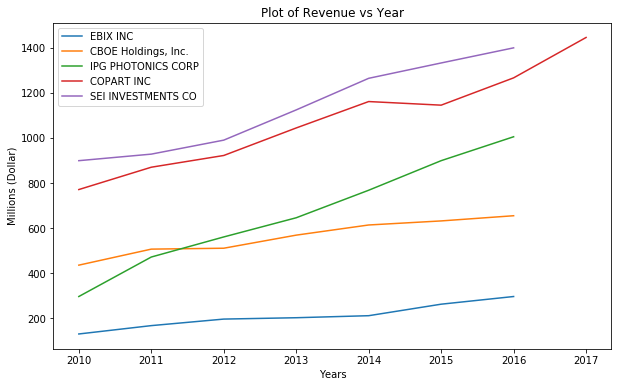

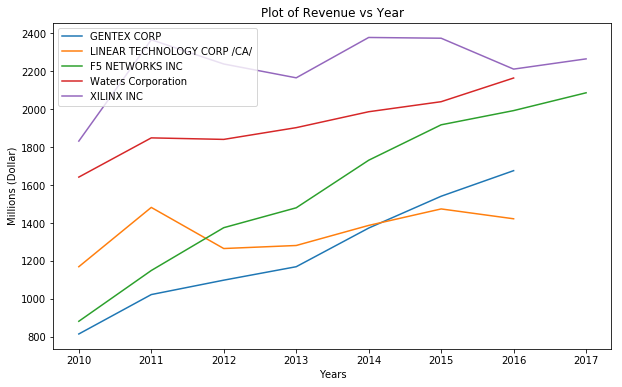

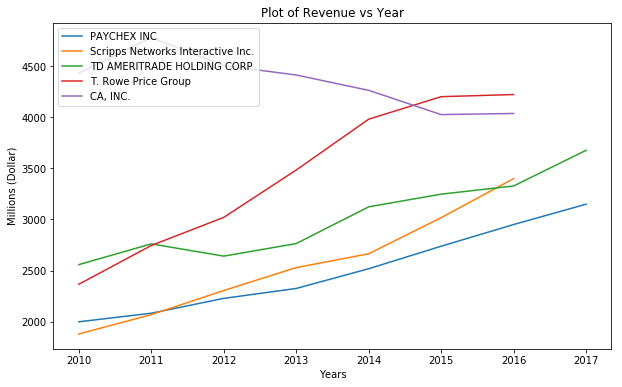

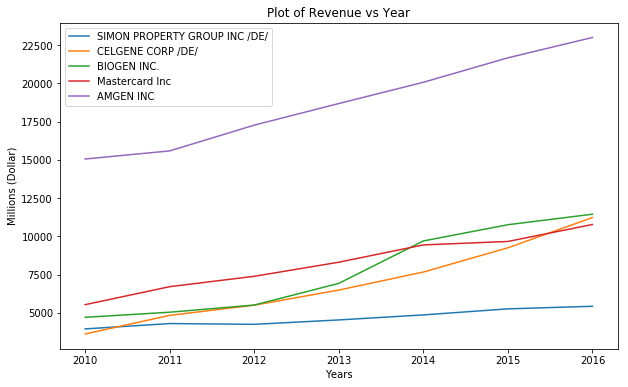

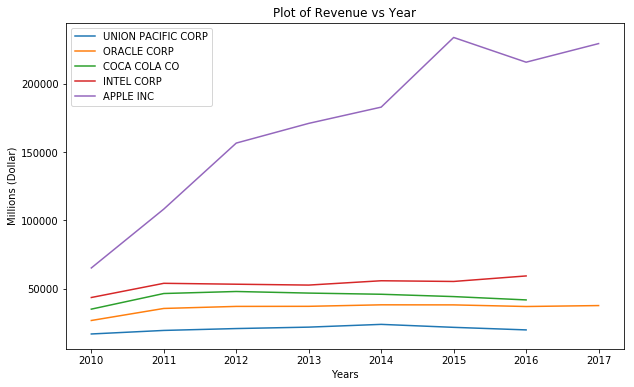

In [137]:
for j in range(5):
    for i in range(j*5,(j+1)*5):
        df = get_company_financial_details_as_df(filtered_ticker_list[i])
        indicator_val = get_indicator('Revenues', df)
        indicator_val = list(map(float, indicator_val))
        plt.plot(df.columns,indicator_val,)
    plt.legend(filtered_company_list[j*5:(j+1)*5], loc='upper left')
    plt.xlabel("Years")
    plt.ylabel("Millions (Dollar)")
    plt.title('Plot of Revenue vs Year')
    plt.show()

In [71]:
df = get_company_financial_details_as_df('CBOE')
df

,2010,2011,2012,2013,2014,2015,2016
Revenues,436,507,511,569,614,632,655
COGS,39,46,45,55,64,68,77
SG&A,114,112,112,125,129,112,122
R&D,0,0,0,0,0,0,0
EBIT,164,239,242,284,312,318,297
EBITDA,None,270.0,272.0,None,350.0,363.0,339.0
"Interest expense, net",0,0,0,0,0,0,5
Abnormal Gains/Losses,None,0,0,0,0,0,-1
Income Taxes,63,99,83,106,118,117,118
Net Income from Discontinued Op.,0,None,0,0,0,0,0
